In [1]:
!pip install mtcnn tensorflow foolbox torch torchvision facenet-pytorch numpy matplotlib



In [2]:
!wget https://drive.google.com/uc?id=1M8R33eK9ZTk4N0dHz6MjFB0mKe3wAfg5 -O celebA.zip
!unzip celebA.zip


--2025-04-21 15:15:03--  https://drive.google.com/uc?id=1M8R33eK9ZTk4N0dHz6MjFB0mKe3wAfg5
Resolving drive.google.com (drive.google.com)... 173.194.174.101, 173.194.174.102, 173.194.174.138, ...
Connecting to drive.google.com (drive.google.com)|173.194.174.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://drive.usercontent.google.com/download?id=1M8R33eK9ZTk4N0dHz6MjFB0mKe3wAfg5 [following]
--2025-04-21 15:15:03--  https://drive.usercontent.google.com/download?id=1M8R33eK9ZTk4N0dHz6MjFB0mKe3wAfg5
Resolving drive.usercontent.google.com (drive.usercontent.google.com)... 108.177.97.132, 2404:6800:4008:c00::84
Connecting to drive.usercontent.google.com (drive.usercontent.google.com)|108.177.97.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2025-04-21 15:15:03 ERROR 404: Not Found.

Archive:  celebA.zip
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of 

In [3]:
!pip install lz4


In [4]:
!pip uninstall -y lz4
!pip install --no-cache-dir lz4

Found existing installation: lz4 4.4.4
Uninstalling lz4-4.4.4:
  Successfully uninstalled lz4-4.4.4
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 17.0 MB/s eta 0:00:00


In [5]:
!pip install numpy scipy torch torchvision mtcnn facenet-pytorch foolbox lz4


In [6]:
!pip install mtcnn


In [9]:
!pip install facenet-pytorch


In [24]:
!pip install foolbox


In [13]:
!pip install --upgrade foolbox




In [32]:
# @title Image Preprocessing
from PIL import Image
import torch
import torchvision.transforms as transforms
import numpy as np
import foolbox as fb
import torchvision.transforms as transforms
from PIL import Image
from facenet_pytorch import InceptionResnetV1
from mtcnn import MTCNN
from PIL import Image
import numpy as np

detector = MTCNN()

def extract_face(image_path):
    image = Image.open(image_path).convert("RGB")
    pixels = np.array(image)
    results = detector.detect_faces(pixels)

    if results:
        x, y, width, height = results[0]['box']
        face = pixels[y:y+height, x:x+width]
        face_image = Image.fromarray(face).resize((160, 160))
        return np.array(face_image)
    return None

image_path = "/content/image2 (1).png"
image = Image.open(image_path)
if image.mode != 'RGB':
    image = image.convert('RGB')


transform = transforms.Compose([
    transforms.Resize((160, 160)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

face_tensor = transform(image).unsqueeze(0)
face_tensor = face_tensor.to(torch.float32)
facenet = InceptionResnetV1(pretrained='vggface2').eval()
def get_face_embedding(face_tensor):
    with torch.no_grad():
        return facenet(face_tensor).numpy().flatten()


embedding = get_face_embedding(face_tensor)


print("Face Embedding (first 10 values):", embedding[:10])



Face Embedding (first 10 values): [ 0.02770687 -0.02673542 -0.01094673 -0.00017338  0.02320965 -0.0344146
  0.04487192  0.03267393 -0.00403792 -0.03502302]


In [31]:
# @title FaceNet Setup
from facenet_pytorch import InceptionResnetV1
import torch

facenet = InceptionResnetV1(pretrained='vggface2').eval()


face_tensor = face_tensor.to(torch.float32)


def get_face_embedding(face_tensor):
    with torch.no_grad():
        return facenet(face_tensor).numpy().flatten()


embedding = get_face_embedding(face_tensor)


print("Face Embedding (first 10 values):", embedding[:10])



Face Embedding (first 10 values): [ 0.02770687 -0.02673542 -0.01094673 -0.00017338  0.02320965 -0.0344146
  0.04487192  0.03267393 -0.00403792 -0.03502302]


In [28]:
# @title Attack Generation
from foolbox.criteria import Misclassification


preprocessing = dict(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5], axis=-3)
fmodel = fb.PyTorchModel(facenet, bounds=(-1, 1), preprocessing=preprocessing)


label = torch.tensor([0], dtype=torch.long)


def generate_fgsm_attack(face_tensor, label, epsilon=0.04):
    attack = fb.attacks.FGSM()
    raw_adversarial, clipped_adversarial, success = attack(fmodel, face_tensor, label, epsilons=epsilon)
    print("FGSM Success:", success)
    print("FGSM Tensor Difference:", (clipped_adversarial - face_tensor).abs().sum().item())
    return clipped_adversarial

def generate_deepfool_attack(face_tensor, label, epsilon=100.0):
    attack = fb.attacks.L2DeepFoolAttack()
    raw_adversarial, clipped_adversarial, success = attack(fmodel, face_tensor, label, epsilons=epsilon)
    print("DeepFool Success:", success)

    print("DeepFool Difference:", (clipped_adversarial - face_tensor).abs().sum().item())
    return clipped_adversarial

def generate_pgd_attack(face_tensor, label):
    from foolbox.criteria import Misclassification
    attack = fb.attacks.PGD()
    epsilons = [0.1]
    criterion = Misclassification(labels=label)

    raw_advs, clipped_advs, success = attack(
        fmodel, face_tensor, criterion=criterion, epsilons=epsilons
    )

    adv_tensor = clipped_advs[0]

    print("PGD Success:", success)
    print("PGD Modification:", (adv_tensor - face_tensor).abs().sum().item())

    return adv_tensor


def generate_bim_attack(face_tensor, label, epsilon=0.1):
    attack = fb.attacks.LinfBasicIterativeAttack()
    raw_adv, clipped_adv, success = attack(fmodel, face_tensor, label, epsilons=epsilon)
    print("BIM Success:", success)
    print("BIM Tensor Difference:", (clipped_adv - face_tensor).abs().sum().item())
    return clipped_adv






fgsm_tensor = generate_fgsm_attack(face_tensor, label)
deepfool_tensor = generate_deepfool_attack(face_tensor, label)
pgd_tensor = generate_pgd_attack(face_tensor, label)
bim_tensor = generate_bim_attack(face_tensor, label)






FGSM Success: tensor([True])
FGSM Tensor Difference: 1957.4022216796875
DeepFool Success: tensor([True])
DeepFool Difference: 0.0
PGD Success: tensor([[True]])
PGD Modification: 3356.166015625
BIM Success: tensor([True])
BIM Tensor Difference: 3153.162353515625


In [17]:
# @title Cosine Similarity

original_embedding = get_face_embedding(face_tensor)
fgsm_embedding = get_face_embedding(fgsm_tensor)
deepfool_embedding = get_face_embedding(deepfool_tensor)
pgd_embedding = get_face_embedding(pgd_tensor)
bim_embedding = get_face_embedding(bim_tensor)


def cosine_similarity(emb1, emb2):
    return np.dot(emb1, emb2) / (np.linalg.norm(emb1) * np.linalg.norm(emb2))

print("Original vs FGSM Attack Similarity:", cosine_similarity(original_embedding, fgsm_embedding))
print("Original vs DeepFool Attack Similarity:", cosine_similarity(original_embedding, deepfool_embedding))
print("Original vs PGD Attack Similarity:", cosine_similarity(original_embedding, pgd_embedding))
print("Original vs BIM Attack Similarity:", cosine_similarity(original_embedding, bim_embedding))



Original vs FGSM Attack Similarity: 0.9381382
Original vs DeepFool Attack Similarity: 1.0
Original vs PGD Attack Similarity: 0.8722627
Original vs BIM Attack Similarity: 0.8410437


In [18]:
# @title L2 (Euclidean) Distance
import numpy as np

def compute_l2_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)
import numpy as np

def compute_l2_distance(embedding1, embedding2):
    return np.linalg.norm(embedding1 - embedding2)

original_embedding = get_face_embedding(face_tensor)
fgsm_embedding = get_face_embedding(fgsm_tensor)
deepfool_embedding = get_face_embedding(deepfool_tensor)
pgd_embedding = get_face_embedding(pgd_tensor)
bim_embedding = get_face_embedding(bim_tensor)


l2_dist = compute_l2_distance(original_embedding, fgsm_embedding )

l3_dist = compute_l2_distance(original_embedding, deepfool_embedding )

l4_dist = compute_l2_distance(original_embedding, pgd_embedding )
l5_dist = compute_l2_distance(original_embedding, bim_embedding )




print("L2 Distance between embeddings for FGSM:", l2_dist)
print("L2 Distance between embeddings for DeepFool:", l3_dist)
print("L2 Distance between embeddings for PGD:", l4_dist)
print("L2 Distance between embeddings for BIM:", l5_dist)




L2 Distance between embeddings for FGSM: 0.35174388
L2 Distance between embeddings for DeepFool: 0.0
L2 Distance between embeddings for PGD: 0.5054452
L2 Distance between embeddings for BIM: 0.56383747


In [19]:
# @title Structural Similarity Index (SSIM)


from skimage.metrics import structural_similarity as ssim
import numpy as np


def compute_ssim(image1, image2):
    image1_np = image1.squeeze().permute(1, 2, 0).detach().cpu().numpy()
    image2_np = image2.squeeze().permute(1, 2, 0).detach().cpu().numpy()

    image1_np = np.clip(image1_np, 0, 1)
    image2_np = np.clip(image2_np, 0, 1)

    return ssim(image1_np, image2_np, channel_axis=-1, data_range=1.0)

ssim_fgsm = compute_ssim(face_tensor, fgsm_tensor)
ssim_deepfool = compute_ssim(face_tensor, deepfool_tensor)
ssim_pgd = compute_ssim(face_tensor, pgd_tensor)
ssim_bim=compute_ssim(face_tensor, bim_tensor)


print("SSIM (Original vs FGSM):", ssim_fgsm)
print("SSIM (Original vs DeepFool):", ssim_deepfool)
print("SSIM (Original vs PGD):", ssim_pgd)
print("SSIM (Original vs BIM):", ssim_bim)





SSIM (Original vs FGSM): 0.9705834
SSIM (Original vs DeepFool): 1.0
SSIM (Original vs PGD): 0.94317085
SSIM (Original vs BIM): 0.95083946


In [20]:
# @title PSNR (Peak Signal-to-Noise Ratio)
from skimage.metrics import peak_signal_noise_ratio as psnr

def compute_psnr(image1, image2):

    image1_np = image1.squeeze().permute(1, 2, 0).cpu().numpy()
    image2_np = image2.squeeze().permute(1, 2, 0).cpu().numpy()


    image1_np = (image1_np + 1) / 2
    image2_np = (image2_np + 1) / 2

    return psnr(image1_np, image2_np, data_range=1.0)
psnr_fgsm = compute_psnr(face_tensor, fgsm_tensor)
psnr_pgd = compute_psnr(face_tensor, pgd_tensor)
psnr_deepfool = compute_psnr(face_tensor, deepfool_tensor)
bims_psnr=compute_psnr(face_tensor, bim_tensor)

print("PSNR (FGSM):", psnr_fgsm)
print("PSNR (PGD):", psnr_pgd)
print("PSNR (DeepFool):", psnr_deepfool)
print("PSNR (BIM):", bims_psnr)




PSNR (FGSM): 35.94141571330487
PSNR (PGD): 31.22259343839634
PSNR (DeepFool): inf
PSNR (BIM): 31.480250057568266


/usr/local/lib/python3.11/dist-packages/skimage/metrics/simple_metrics.py:168: RuntimeWarning: divide by zero encountered in scalar divide
  return 10 * np.log10((data_range**2) / err)


In [21]:
# @title Perturbation Magnitude (L-infinity norm / Max difference)
import torch

def compute_perturbation_stats(original_tensor, adversarial_tensor):

    diff = (adversarial_tensor - original_tensor).abs()

    max_diff = diff.max().item()


    mean_diff = diff.mean().item()


    l2_diff = diff.norm().item()

    return max_diff, mean_diff, l2_diff


max_diff_fgsm, mean_diff_fgsm, l2_diff_fgsm = compute_perturbation_stats(face_tensor, fgsm_tensor)
max_diff_deepfool, mean_diff_deepfool, l2_diff_deepfool = compute_perturbation_stats(face_tensor, deepfool_tensor)
max_diff_pgd, mean_diff_pgd, l2_diff_pgd = compute_perturbation_stats(face_tensor, pgd_tensor)
max_diff_bim, mean_diff_bim, l2_diff_bim = compute_perturbation_stats(face_tensor, bim_tensor)

print("FGSM - Max Diff:", max_diff_fgsm, "Mean Diff:", mean_diff_fgsm, "L2 Diff:", l2_diff_fgsm)
print("DeepFool - Max Diff:", max_diff_deepfool, "Mean Diff:", mean_diff_deepfool, "L2 Diff:", l2_diff_deepfool)
print("PGD - Max Diff:", max_diff_pgd, "Mean Diff:", mean_diff_pgd, "L2 Diff:", l2_diff_pgd)
print("BIM - Max Diff:", max_diff_bim, "Mean Diff:", mean_diff_bim, "L2 Diff:", l2_diff_bim)


FGSM - Max Diff: 0.04000002145767212 Mean Diff: 0.025487007573246956 L2 Diff: 8.84373664855957
DeepFool - Max Diff: 0.0 Mean Diff: 0.0 L2 Diff: 0.0
PGD - Max Diff: 0.10000002384185791 Mean Diff: 0.04278184100985527 L2 Diff: 15.225859642028809
BIM - Max Diff: 0.10000002384185791 Mean Diff: 0.0410568006336689 L2 Diff: 14.780810356140137


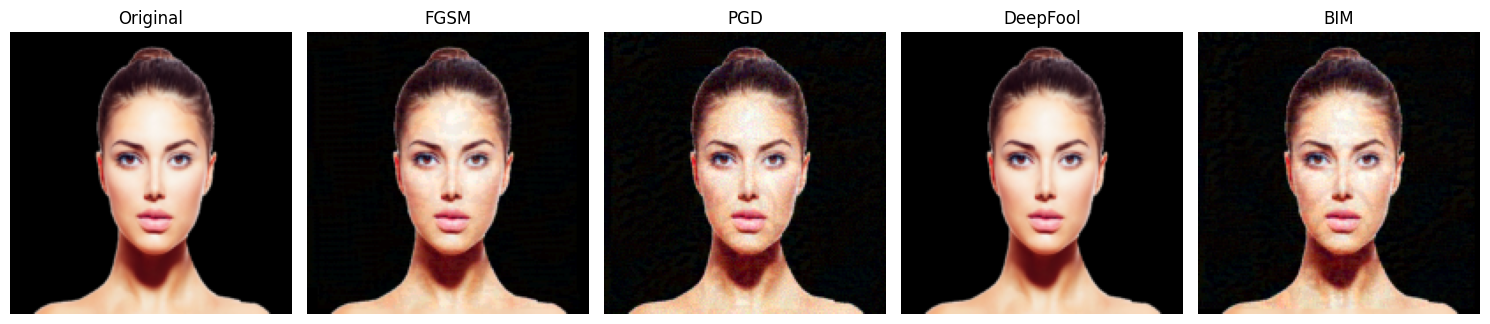

<Figure size 640x480 with 0 Axes>

In [33]:
# @title Original vs Adversarial Samples
import matplotlib.pyplot as plt

def show_adversarial_images(original, attacks, titles):

    all_images = [original] + attacks
    all_titles = ['Original'] + titles

    plt.figure(figsize=(15, 4))
    for i, (img, title) in enumerate(zip(all_images, all_titles)):
        img_np = img.detach().cpu().squeeze().permute(1, 2, 0).numpy()
        img_np = (img_np + 1) / 2  # if normalized to [-1, 1]
        plt.subplot(1, len(all_images), i + 1)
        plt.imshow(img_np)
        plt.axis('off')
        plt.title(title)
    plt.tight_layout()
    plt.show()
    plt.savefig('adversarial_images.png', dpi=300, bbox_inches='tight')

show_adversarial_images(
    face_tensor,
    [fgsm_tensor, pgd_tensor, deepfool_tensor, bim_tensor],
    ['FGSM', 'PGD', 'DeepFool', 'BIM']
)

